<div style="width: 100%; overflow: hidden; text-align:center;">
    <h1>INF-477 Redes Neuronales Artificiales</h1>
    <h2>Tarea 1 - Perceptrones Multicapa o Redes FF</h2><br/>
    <div style="width: 300px; float: left;">
        <h3>Sebastián Orellana</h3>
        <h4>``sebastian.orellan.12@sansano.usm.cl``</h4>
        <h4>201273591-2</h4>
    </div>
    <div style="width: 300px; float: right;">
        <h3>Jeremy Rojas</h3>
        <h4>``jeremy.rojas.12@sansano.usm.cl``</h4>
        <h4>2012735XX-X</h4>
    </div>
</div>

## 1. Rol de las Capas Ocultas de una ANN

Para esta primera sección del documento se espera demostrar empíricamente la importancia de capas ocultas dentro de una red neuronal artificial en el contexto de problemas cuya solución no es una función lineal de sus atributos. Haremos uso de las siguientes librerías:

In [57]:
# Librerías utilizadas

# a)
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np

# b)
from sklearn.linear_model import perceptron
from mlxtend.plotting import plot_decision_regions

# c)
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers

Using Theano backend.


#### a) Cargar conjunto de datos

Para generar el conjunto de datos linealmente inseparable sobre el cual podamos trabajar (esencialmente dos semi-círculos de radio $\sqrt{2}$, uno centrado en (0.0, 0.5) y el otro en (1.0, 0.0)) se implementa una función generadora de medias lunas de _n_ datos con un ruido _r_ asociado. Para esto se hace uso de la función *make_moons* ofrecida por *scikit-learn*: 

In [3]:
def generar_lunas(n, r):
    X, y = make_moons(n, noise=r)
    return X, y

Por medio de la función *generar_lunas(n, r)*, se crea un conjunto de entrenamiento de 500 puntos y ruido 0.2: 

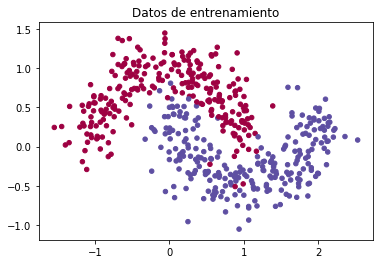

In [4]:
X_train, y_train = generar_lunas(500, 0.2)
plt.scatter(X_train[:,0], X_train[:,1], s=20, c=y_train, cmap=plt.cm.Spectral)
plt.title("Datos de entrenamiento")
plt.show()

Análogamente para la generación del conjunto de datos de prueba:

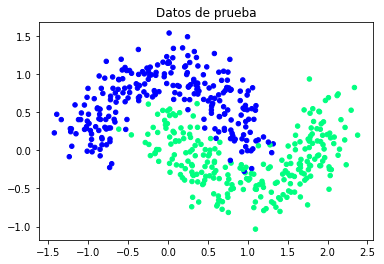

In [5]:
X_test, y_test = generar_lunas(500, 0.2)
plt.scatter(X_test[:,0], X_test[:,1], s=20, c=y_test, cmap=plt.cm.winter)
plt.title("Datos de prueba")
plt.show()

En ambos casos los subconjuntos generados presentan dos clases: visaulizadas en azul y rojo en los datos de entrenamiento, y azul rey y verde en los datos de prueba.

Así, es de nuestro interés entrenar un clasificador de aprendizaje automático que prediga la clase correcta dado un input $(x_{1}, x_{2}) \in \mathbb{R}^2$. Considerando que los datos no son linealmente separables, no es posible trazar una línea recta que separe las dos clases. Esto implica que clasificadores lineales no serán capaces de ajustar los datos a menos que se aplique un proceso previo de ingeniería de atributos. Luego, nuestra meta es demostrar la importancia de las capas escondidas dentro de una red neuronal artificial que permiten resolver satisfactoriamente el problema en cuestión.

#### b) Neurona artificial individual

Para demostrar experimentalmente que una neurona artificial individual no puede resolver satisfactoriamente el problema anterior haremos uso del módulo *sklearn.linear_model.Perceptron* facilitando el procedimiento. Se entiende que el empleo del algoritmo del perceptrón de Rosenblatt implica una función escalón como función de activación, esto es:

$g(\xi)= \left\{\begin{array}{lc}
            1 &  si  & \xi > 0 
             \\ 0 &   si  & \xi \leq 0 \\
             \end{array}
   \right.$

, lo cual es factible en un contexto de clasificación binaria. Además, el método de entrenamiento exige una corrección (en dirección de $x$) en los pesos asociados a cada dimensión de la entrada luego de toda clasificación errónea sobre el conjunto de prueba.

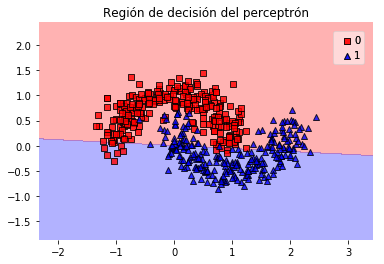

Peso dimensión de entrada 1 (w1): -0.000355099188483
Peso dimensión de entrada 2 (w2): -0.00607993894803
Precisión: 77.2%


In [34]:
neurona_individual = perceptron.Perceptron(n_iter=100, verbose=0, random_state=None, fit_intercept=True, eta0=0.002)
neurona_individual.fit(X_train, y_train)

fig = plot_decision_regions(X=X_train, y=y_train, clf=neurona_individual, legend=1)
plt.title("Región de decisión del perceptrón")
plt.show()

print("Peso dimensión de entrada 1 (w1): " + str(neurona_individual.coef_[0,0]))
print("Peso dimensión de entrada 2 (w2): " + str(neurona_individual.coef_[0,1]))
print("Precisión: " + str(neurona_individual.score(X_test, y_test)*100) + "%")

El gráfico obtenido muestra el límite de decisión aprendido por el perceptrón. Se visualiza la intención de separar ambas clases de la mejor manera posible usando una línea recta, sin lograr capturar la "forma lunar" que una clasificación óptima exige, característica que lo convierte en un problema linealmente no separable.

Un análisis cuantitativo otorgado por la precisión con que se clasifican los datos de prueba, arroja que con una neurona artificial es posible resolver el problema _moons_ con una precisión insuficientemente mayor a 50%, correspondiente a un resultado aleatorio esperado en un contexto de clasificación binaria. Si bien las condiciones espaciales que ambos semi-círculos proponen permiten observar gráficamente que el límite de decisión tiende a clasificar la mayor parte del conjunto de datos correctamente (77.2% de los datos), existe una porción significativa de puntos que se asocian a la clase incorrecta (22.8% de los datos), entorpeciendo la veracidad de la predicción. 

De esta forma, se concluye que el problema _moons_ necesita más que una combinación lineal de las dimensiones de entrada (otorgada por los pesos definitivos _w1_ y _w2_) para separar ambas clases. Luego, queda demostrado experimentalmente que una neurona artificial individual, sin importar la función de activación utilizada (al no ser parte del proceso de aprendizaje directamente) no es capaz de resolver satisfactoriamente el problema anterior, necesitando al menos una capa de perceptrones adicional.

#### c) Perceptrón multicapas

Para demostrar experimentalmente que un perceptrón multicapas puede resolver satisfactoriamente el problema anterior haremos uso del módulo *keras.models.Sequential* facilitando el procedimiento. La arquitecura empleada (tras un proceso de diseño guiado por prueba y error) consiste en una capa escondida con 20 neuronas computando no linealidad por medio de la función de activación _Rectifier Linear (ReLu)_, y una única unidad de salida con función de activación sigmoidal. La capa de entrada se mantiene con respecto a la considerada en b). Utilizando para el entrenamiento un número de ciclos igual 500, _Stochastic gradient descent_ con tasa de aprendizaje 0.08 como optimizador, y _cross-entropy binaria_ como función de pérdida, se obtienen los siguientes resultados:

100/500 [=====>........................] - ETA: 0s
Loss:  7.77008779347 %
Accuracy:  96.6000008583 %


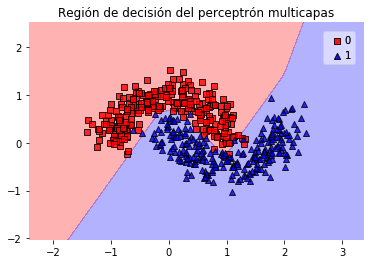

In [13]:
set_epoch=500
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=2))
model.add(Dense(1, activation='sigmoid'))
sgd = optimizers.SGD(lr=0.08)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar a la red
model.fit(X_train, y_train, epochs=set_epoch, verbose=0)

# Evaluar la neurona
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=100)
print('\nLoss: ', loss_and_metrics[0]*100,"%") 
print ("Accuracy: ", loss_and_metrics[1]*100,"%")

fig = plot_decision_regions(X=X_test, y=y_test,clf=model, legend=1)
plt.title("Región de decisión del perceptrón multicapas")
plt.show()

En contraste al gráfico obtenido en b), se observa que el límite de decisión coincide con bastante certeza con la distribución del problema _moons_, ofreciendo la "forma lunar" esperada para una buena clasificación, y desligándose de la dependencia que significa que un problema no se linealmente separable.

Cuantitativamente el procedimiento entrega un resultado de casi el 96% de precisión y una pérdida menor a un 10%, interpretable como un aprendizaje satisfactorio. Esto puede confirmarse gráficamente al visualizar una cantidad marginal de puntos clasificados erróneamente (aproximadamente un 4% del total de datos). 

Finalmente, para resolver el problema _moons_ fue necesario el uso de una capa escondida ofrecida por un perceptrón multicapas, donde cada neurona se encargará de establecer sus propios límites de decisión, que conjuntamente permitirán obtener la salida esperada.  Luego, queda demostrado experimentalmente que un perceptrón multicapas con las características señaladas con anterioridad es capaz de resolver satisfactoriamente (satisfacción del 96%) el problema planteado en a), ofreciendo una óptima predicción de las clases que intervienen en la decisión.

## 2. Back-propagation from Scratch

Esta sección tiene por objetivo implementar una red neuronal artificial FF que use SGD (_Stochastic gradient descent_) como método de optimización y _Back-propagation_ para el cálculo de los gradientes asociados. Por fines pedagógicos, se llevará a cabo esta tarea sin emplear librerías especializadas. Así, únicamente se hará uso de las siguientes librerías:

In [1]:
#Librerías utilizadas
#Para operaciones matemáticas
import numpy as np

#b)
from sklearn.preprocessing import StandardScaler
import pandas as pd

#c)
import matplotlib.pyplot as plt

#### a) Funciones para el aprendizaje

En principio la implementación fue pensada para una red FF con una capa escondida (H neuronas) y O neuronas de salida, sin embargo podría extenderse sin mayores dificultades hacia una red neuronal con más de una capa escondida.

Para una mejor comprensión del proceso este se presentará en cuatro módulos:  

##### i) Asignación inicial a los pesos: 

En términos prácticos, cada capa de una red neuronal (exceptuando la capa de entrada) será representada por un arreglo de diccionarios, donde cada diccionario corresponderá a una neurona de la capa. Así, cada diccionario almacenará información pertinente a cada neurona: una lista de pesos recibidos por la capa anterior, la salida que propaga y un término asociado con su responsabilidad en el error resultante.

Luego, creamos la función *inicializar_red* que recibe como parámetro la arquitectura esperada de la red neuronal, esto es, el tamaño de la capa de entrada (determinada por la dimensionalidad del dataset en cuestión), el tamaño de la capa escondida, y el tamaño de la capa de salida (determinada por la cantidad de clases dentro de las cuales se clasificarán las entradas). Así, inicializar la red significa la asignación aleatoria de los pesos de cada neurona de la capa escondida y de salida, usualmente seteados en un rango [0,1]. Notar que cada neurona se le es asignado un peso adicional con respecto a la cantidad de neuronas de la capa anterior, debido a que la representación de entrada incluye el _bias_ con el fin de simplificar el modelo lineal.  

In [2]:
def inicializar_red(n_entrada, n_escondida, n_salida):
    crear_red = list()
    capa_escondida = [{'pesos': np.random.random_sample((n_entrada + 1,)).tolist()} for i in range(n_escondida)]
    capa_salida = [{'pesos':np.random.random_sample((n_escondida + 1,)).tolist()} for i in range(n_salida)]
    crear_red.append(capa_escondida)
    crear_red.append(capa_salida)
    return crear_red

##### ii) Forward pass

Recordar que cada componente de la red aplica una no linealidad a su salida. Por simplicidad se asume que todas las neuronas implementan funciones de activación diferenciables. En particular, para evidenciar el buen funcionamiento de nuestra red se utilizará una función de activación sigmoidal, donde: 

$g(\xi)= \sigma(\xi) = \frac{1}{1+e^{-x}}$

In [3]:
#Función de activación utilizada
def sigmoid(activation):
    return 1.0 / (1.0 + np.exp(-activation))

Para calcular la salida de la red neuronal es preciso calcular la salida de cada unidad que la compone. Se crea la función *forward_pass* que recibe como parámetros la red con los pesos ya inicializados para cada neurona, y una fila de la entrada a clasificar. De esta forma, se computa cada salida individual (generando un término dentro del diccionario asociado a la salida de la neurona), recorriendo la red y propagando los resultados de cada capa al convertirlos en entrada de la siguiente. Adicionalmente se crea una función de apoyo *calculo_lineal* para computar la salida lineal de cada neurona. 

In [4]:
def calculo_lineal(pesos, inputs):
    #para sumar bias
    resultado = pesos[-1]
    for i in range(len(pesos)-1):
        resultado += pesos[i] * inputs[i]
    return resultado
  
def forward_pass(red, fila):
    entrada = fila
    for capa in red:
        entrada_siguiente = []
        for neurona in capa:
            salida_lineal = calculo_lineal(neurona['pesos'], entrada)
            neurona['salida'] = sigmoid(salida_lineal)
            entrada_siguiente.append(neurona['salida'])
        entrada = entrada_siguiente
    return entrada

##### iii) Backward pass

Para que nuestra red neuronal sea capaz de aprender los pesos adecuados que impliquen una óptima generalización, y como parte del proceso de back-propagation, es necesario el cálculo de la derivada de cada salida individual. Dado que estamos empleando $\sigma(\xi)$ como función de activación, consideraremos:

$\sigma'(\xi) = \sigma(\xi)(1-\sigma(\xi))$

In [5]:
# Derivada de función sigmoidal evaluada en cada salida
def derivada_sigmoid(salida):
    return salida * (1.0 - salida)

Además, entendiendo el proceso de aprendizaje como una minimización de la función costo total, se emplea una pérdida cuadrática para esta labor (también diferenciable por simplicidad):

$E(f(x),y)=(f(x)-y)^2$, donde _'f(x)'_ es la salida de la red, e _'y'_ es la salida esperada.

También es importante considerar el gradiente de esta función de pérdida cuadrática en un contexto de SGD. Para la capa de salida de la red, interpretado como el aporte de las salidas de cada neurona de dicha capa en el error final (para entender el cálculo del gradiente para capas previas ver demostración de Back-propagation en _Anexos_), se tiene:

$ \frac{\partial E}{\partial a_{s}^{(L)}}=(a_{s}^{(L)}-y_{s})=(f_{ANN}(x)_{k}-y_{k})$, para cada neurona de la capa final.

A continuación definimos la función *backward_pass*, que recibe como parámetros la red con cada diccionario (neurona) con sus respectivos pesos y salida ya asignados, y una etiqueta asociada a la entrada (en formato _one hot encoding$^{1}$_) que permita el cálculo del error del proceso. Cabe destacar que para el cálculo de la responsabilidad en el error de salidas de neuronas en capas internas, se emplea un recorrido de la red en reversa, debido a la dependencia del cálculo con respecto a la capa de adelante y el conocimiento previo de este valor para la capa de salida (ver ecuación definida para $\frac{\partial E}{\partial a_{s}^{(L)}}$).

Finalmente, la función se encarga de agregar un último término a cada diccionario (neurona) asociado a su responsabilidad en el error final ($\frac{\partial E}{\partial a_{s}^{(l+1)}}$). Almacenar este valor escalar es importante para la posterior actualización de pesos de la red.

In [6]:
def backward_pass(red, etiqueta):
    #Recorrido inverso de la red
    for i in reversed(range(len(red))):
        capa = red[i]
        errores = list()
        #Para capas escondidas
        if i != len(red)-1:
            for j in range(len(capa)):
                error = 0.0
                #Por regla de la cadena considerar términos de la capa de adelante
                for neurona in red[i + 1]:
                    error += (neurona['pesos'][j] * neurona['resp_error'])
                errores.append(error)
        #Para capa de salida
        else:
            for j in range(len(capa)):
                neurona = capa[j]
                errores.append(neurona['salida'] - etiqueta[j])
        #Seteo de responsabilidad en error
        for j in range(len(capa)):
            neurona = capa[j]
            neurona['resp_error'] = errores[j] * derivada_sigmoid(neurona['salida'])

$^{1}$ One hot encoding entrega un 1 en el índice del arreglo que sea equivalente a la clase que se desea etiquetar. Por ejemplo, en un conjunto de datos con tres clases posible, existe un registro de clase dos cuya etiqueta se representa: [0 1 0].

##### iv) Rutina de entrenamiento

Por último, se implementa la rutina principal de entrenamiento (función _entrenar_), adoptando por simplicidad, la variante cíclica de SGD (un ejemplo a la vez, pero iterando cíclicamente sobre el conjunto de entrenamiento) con una tasa de aprendizaje $\eta$ (_lr_) y número de ciclos fijos (*n_epochs*). Notar que también recibe como parámetro el número de neuronas de salidas de la red, interpretado como la cantidad de posibles clases K que cada registro podría tomar, y utilizado para darle formato one hot encoding a cada etiqueta. Se asume que el dataset utilizado incluye la etiqueta en el último valor de cada fila de entrada.

Básicamente se aplica sobre cada fila del conjunto de entrenamiento las funciones *forward_pass* y *backward_pass* explicadas en los módulos anteriores, y una función auxiliar encargada de hacer efectivo la actualización de los pesos. Matemáticamente, *actualizar_pesos* encuentra $\frac{\partial E}{\partial w_{s}^{(l)}} = \frac{\partial E}{\partial a_{s}^{(l+1)}} \frac{\partial a_{s}^{(l+1)}}{\partial w_{s}^{(l)}}$, lo multiplica por la tasa de aprendizaje y se lo resta a cada peso actual de la red.

In [33]:
#Para actualizar pesos luego de cada salida de la red
def actualizar_pesos(red, fila, lr):
    for i in range(len(red)):
        salida_anterior = fila[:-1]
        if i != 0:
            salida_anterior = [neurona['salida'] for neurona in red[i - 1]]
        for neurona in red[i]:
            for j in range(len(salida_anterior)):
                neurona['pesos'][j] -= lr * neurona['resp_error'] * salida_anterior[j] * derivada_sigmoid(neurona['salida'])
            #para el bias    
            neurona['pesos'][-1] -= lr * neurona['resp_error'] * 1 * derivada_sigmoid(neurona['salida'])

def entrenar(red, n_salidas, dataset, lr, n_epoch):
    perdida = []
    ciclos = []
    error_clasificacion = []
    for ciclo in range(n_epoch):
        error_total = 0
        mal_clasificado = 0
        #Recorrido sobre el dataset
        for fila in dataset:
            salidas = forward_pass(red, fila)
            etiqueta_one_hot_encoding = [0 for i in range(n_salidas)]
            etiqueta_one_hot_encoding[fila[-1]-1] = 1
            backward_pass(red, etiqueta_one_hot_encoding)
            actualizar_pesos(red, fila, lr)
            #Función de pérdida sobre la entrada
            error_total += sum([(salidas[i] - etiqueta_one_hot_encoding[i])**2 for i in range(len(etiqueta_one_hot_encoding))])
            #Error de clasificación
            if ((etiqueta_one_hot_encoding.index(max(etiqueta_one_hot_encoding))+1)!=(salidas.index(max(salidas))+1)):
                mal_clasificado+=1
        perdida.append(error_total/len(dataset))
        ciclos.append(ciclo+1)
        error_clasificacion.append(mal_clasificado/len(dataset))
    return ciclos, perdida, error_clasificacion

#### b) Predicciones de la red

A continuación, se escribe una función que permita hacer predicciones mediante una instanciación de red FF generada en a) con una capa escondida (H neuronas) y O neuronas de salida. Nuevamente se restringe únicamente a numpy para el uso de librerías. 

Para esto generamos una función *prediccion_vectorizada* que implementa _forward pass_ sobre un dataset determinado (parámetro de la función) por medio de una red dada (también parámetro). Ésta función a su vez hace uso de una función auxiliar *predicción_fila*, la cual es quien efectivamente implementa el _forward pass_ para cada registro, entregando la salida de la red interpretada como la clase en que clasifica la entrada.

In [8]:
def prediccion_fila(red, fila):
    salidas = forward_pass(red, fila)
    return (salidas.index(max(salidas))+1)
    
def prediccion_vectorizada(red,dataset):
    for fila in dataset:
        prediccion = prediccion_fila(red, fila)
        print('Etiqueta=%d || Valor arrojado por la red=%d' % (fila[-1], prediccion))

#### c) Prueba

Con el fin de demostrar que la implementación expuesta en a) y b) funcionan en un problema de clasificación, se utiliza el dataset seeds correspondiente a 210 distintos tipos de semillas, representados cada uno por 7 atributos numéricos, y clasificados dentro de 3 posibles clases. Por conveniencia los datos son normalizados antes de trabajar con el modelo.

In [21]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
df = pd.read_csv(url, sep=r'\s+', header=None)
X = df.ix[:,0:6]
y = df.ix[:,7]
scaler = StandardScaler().fit(X)
dataset = scaler.transform(X)
print("Dimensión del dataset: ", dataset.shape)

Dimensión del dataset:  (210, 7)


Adicionalmente, para dar el formato de entrada esperado por la red neuronal generada, se incluye cada etiqueta como una dimensión adicional del conjunto de datos.

In [22]:
dataset_lista = dataset.tolist()
n=0
for fila in dataset_lista:
    fila.append(int(y[n]))
    n+=1

Luego, se determina la densidad de la capa de entrada (a partir de la dimensionalidad de cada fila del dataset) y capa de salida (considerando las posibles clases en que cada semilla puede ser clasificada)

In [23]:
neuronas_salida = len(set([fila[-1] for fila in dataset_lista]))
neuronas_entrada = len(dataset_lista[0]) - 1

Inicializamos las red con una cantidad de neuronas en la capa escondida igual a 5:

In [44]:
np.random.seed(1)
neuronas_escondidas = 5
red = inicializar_red(neuronas_entrada, neuronas_escondidas, neuronas_salida)

Y entrenamos nuestra red una cantidad de ciclos igual a 1000, con una tasa de aprendizaje del 0.5. Modificar los pesos un 50% del máximo posible entregado por backpropagation es sólo con fines expositivos de la evolución del error. Usualmente el valor de la tasa de aprendizaje es inferior, debido a que valores más pequeños incrementan la verosimilitud de la red neuronal al encontrar aquellos pesos que permitan generalizar de mejor manera, más que aquellos pesos que tienden a una más rápida minimización del error (convergencia prematura). Notar que sólo utilizamos los primeros 200 registros del dataset, para conservar una pequeña fracción de los datos para el conjunto de prueba.

Pérdida en ciclo final:  0.0230595628565
Error clasificación en ciclo final:  0.005 %


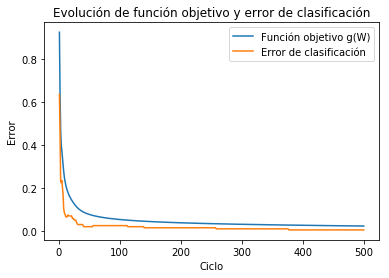

In [45]:
epochs = 500
tasa_aprendizaje = 0.5
ciclo, perdida, clasificacion = entrenar(red, neuronas_salida, dataset_lista[:200], tasa_aprendizaje, epochs)
print("Pérdida en ciclo final: ", perdida[-1])
print("Error clasificación en ciclo final: ", clasificacion[-1], "%")

plt.plot(ciclo, perdida)
plt.plot(ciclo, clasificacion)
plt.xlabel('Ciclo')
plt.ylabel('Error')
plt.legend(['Función objetivo g(W)', 'Error de clasificación'], loc='upper right')
plt.title('Evolución de función objetivo y error de clasificación')
plt.show()

Considerando que para esta implementación se utiliza una función de pérdida cuadrática, la minimización de la función objetivo se reduce a minimizar el promedio de las sumas de las diferencias al cuadrado de los términos dentro del vector de salida de la red y el vector one hot encoding de la etiqueta. Por ejemplo, para una entrada con etiqueta [0 1 0] y clasificado por la red correctamente en la clase 2 por medio del vector [0.3 0.8 0.1] (correspondiente al vector generado por las salidas de cada neurona de la capa final, donde cada término pertenece a un rango [0,1] dado por el mapeo de la función sigmoidal), incurre en la función objetivo en $(0.3-0)^2+(0.8-1)^2+(0.1-0)^2 = 0.14$. De esta forma, la suma del aporte en promedio de cada salida de la red resulta en el valor de la función de pérdida para determinado ciclo.

Así, la figura resultante para la evolución de la función objetivo muestra valores promedios relativamente altos en las fases iniciales del proceso de entrenamiento, evidenciando que los pesos de la red aún no han sido aprendidos correctamente. Dado el método de entrenamiento utilizado, donde los pesos son actualizados luego de cada salida obtenida por la red, es de esperarse que la clasificación se vuelva cada vez más precisa, incurriendo en valores cada vez más pequeños de la función a optimizar. Gráficamente puede apreciarse una distribución ley de potencia, con una cola pesada que tiende lentamente a una pérdida nula a medida que la cantidad de ciclos de entrenamiento aumenta (el menor valor obtenido para el ciclo 500 corresponde a 0.0230595628565 en la función objetivo), y de esta forma sugiriendo que el proceso de aprendizaje está siendo productivo.

Análogamente, se expone la evolución del error de clasificación. Aunque al definir el error de clasificación como el porcentaje de fallos de la red al predecir clases para nuevas entradas, este se asocia al entrenamiento de la red más que a su testeo, con la intención de asociarlo con la cantidad de ciclos del aprendizaje. Así, el gráfico muestra una tendencia similar a la reflejada por la función de pérdida (pero con una caída más rápida del error), lo cual tiene sentido al considerar que a medida que se aprenden correctos pesos, la clasificación también debiese tender a resultados más precisos (error del 0.005% para el último ciclo realizado).

Si bien no existe un conjunto de datos de prueba, se intenta simluar una primera iteración del procedimiento tradicional en escenarios de escasez datos: validar reiteradas ocaciones sobre distintas porciones muy pequeñas extraídas del conjunto de entrenamiento, obteniendo una precisión de prueba final igual al promedio de cada iteración. Esto explica por qué se selecciona un subconjunto tan pequeño para el conjunto de prueba, entendiendo también un contexto académico donde resulta relevante comprobar aprendizaje en la red generada.

In [29]:
prediccion = prediccion_vectorizada(red, dataset_lista[200:])

Etiqueta=3 || Valor arrojado por la red=3
Etiqueta=3 || Valor arrojado por la red=1
Etiqueta=3 || Valor arrojado por la red=3
Etiqueta=3 || Valor arrojado por la red=3
Etiqueta=3 || Valor arrojado por la red=3
Etiqueta=3 || Valor arrojado por la red=1
Etiqueta=3 || Valor arrojado por la red=3
Etiqueta=3 || Valor arrojado por la red=3
Etiqueta=3 || Valor arrojado por la red=3
Etiqueta=3 || Valor arrojado por la red=3


Comprobándose así un porcentaje de correcta clasificación bastente alto al considerar el tamaño del conjunto de prueba, donde para diez semillas etiquetadas en la clase 3, en ocho casos la red arroja la clasificación esperada.  

#### d) Empleo de weight-decay

El uso de *weight-decay* se justifica en escenarios en que se desea evitar *overfitting* en el proceso de entrenamiento. En la práctica, corresponde a un nuevo término que penaliza los pesos grandes y limita efectivamente la libertad del modelo. Aplicando SGD a la nueva función de pérdida $E$, se obtiene para la actualización de pesos:

$w_{i}=w_{i}-\eta \frac{\partial E}{\partial w_{i}}- \eta \lambda w_{i}$

, donde el nuevo término $\eta \lambda w_{i}$ proviene de la regularización que obliga a los pesos disminuir en proporción a su tamaño.

De esta forma, para obtener una variante de los programas expuestos en a) y b), basta con modificar la función *actualizar_pesos* de la siguiente forma:

In [49]:
#Para actualizar pesos luego de cada salida de la red, aplicando weight-decay
def actualizar_pesos_wd(red, fila, lr, lambda_):
    for i in range(len(red)):
        salida_anterior = fila[:-1]
        if i != 0:
            salida_anterior = [neurona['salida'] for neurona in red[i - 1]]
        for neurona in red[i]:
            for j in range(len(salida_anterior)):
                neurona['pesos'][j] -= lr * neurona['resp_error'] * salida_anterior[j] * derivada_sigmoid(neurona['salida']) - lr * lambda_ * neurona['pesos'][j]
            #para el bias    
            neurona['pesos'][-1] -= lr * neurona['resp_error'] * 1 * derivada_sigmoid(neurona['salida']) - lr * lambda_ * neurona['pesos'][j]

Y los parámetros de la función *entrenar* que es desde donde se efectúa la llamada:

In [56]:
def entrenar_wd(red, n_salidas, dataset, lr, n_epoch, lambda_):
    perdida = []
    ciclos = []
    error_clasificacion = []
    for ciclo in range(n_epoch):
        error_total = 0
        mal_clasificado = 0
        #Recorrido sobre el dataset
        for fila in dataset:
            salidas = forward_pass(red, fila)
            etiqueta_one_hot_encoding = [0 for i in range(n_salidas)]
            etiqueta_one_hot_encoding[fila[-1]-1] = 1
            backward_pass(red, etiqueta_one_hot_encoding)
            actualizar_pesos_wd(red, fila, lr,lambda_)
            #Función de pérdida sobre la entrada
            error_total += sum([(salidas[i] - etiqueta_one_hot_encoding[i])**2 for i in range(len(etiqueta_one_hot_encoding))])
            #Error de clasificación
            if ((etiqueta_one_hot_encoding.index(max(etiqueta_one_hot_encoding))+1)!=(salidas.index(max(salidas))+1)):
                mal_clasificado+=1
        perdida.append(error_total/len(dataset))
        ciclos.append(ciclo+1)
        error_clasificacion.append(mal_clasificado/len(dataset))
    return ciclos, perdida, error_clasificacion

Finalmente, y análogo al proceso anterior, basta con agregar el parámetro $\lambda$ (Ejemplo: $\lambda=0.03$) para incluir weight-decay en el entrenamiento:

In [ ]:
np.random.seed(1)
neuronas_escondidas = 5
red = inicializar_red(neuronas_entrada, neuronas_escondidas, neuronas_salida)

epochs = 500
tasa_aprendizaje = 0.5
ciclo, perdida, clasificacion = entrenar_wd(red, neuronas_salida, dataset_lista[:200], tasa_aprendizaje, epochs, 0.03)

## Anexos

###### Demostración back-propagation:

Considerando la función de pérdida $g(W)$ a minimizar sobre $W$:

$g(W)=\frac{1}{n} \sum_{i=1}^{n} E(f(x)_{i},y_{i})$

Como para este documento (*Sección 2*) se utilizó una función de pérdida cuadrática:

$E(x_{i}, y_{i}) = \frac{1}{2} \sum_{k=1}^{K}(f_{ANN}(x)_{k}-y_{k})^2$, donde K es la cantidad de clases.

Luego, el término requerido por back-propagation es:

$\frac{\partial g}{\partial w_{s}^{l}} = \frac{1}{n} \sum_{i=1}^{n} \frac{\partial E}{\partial w_{s}^{l}}$

Equivalente a encontrar para cada neurona, el efecto de sus pesos sobre el error final. Por regla de la cadena se tiene:

$\frac{\partial E}{\partial w_{s}^{l}} = \frac{\partial E}{\partial a_{s}^{l+1}} \frac{\partial a_{s}^{l+1}}{\partial w_{s}^{l}}$, con $a_{s}^{l+1}= \sigma (w_{s}^{l} \cdot a^{l}) \implies \frac{\partial a_{s}^{l+1}}{\partial w_{s}^{l}}= \sigma'(\cdot) a^{l}$

Además, el término $\frac{\partial E}{\partial a_{s}^{l+1}}$ es conocido para la última capa:

$\frac{\partial E}{\partial a_{s}^{L}}= a_{s}^{L}-y$

Por lo que es posible definir recursivamente el efecto de cada neurona de las capas esconidas en base a sus derivadas parciales:

$\frac{\partial E}{\partial a_{s}^{l+1}}= \sum_{r=1}^{S_{l+2}} \frac{\partial E}{\partial a_{r}^{l+2}}\frac{\partial a_{r}^{l+2}}{\partial a_{s}^{l+1}}$

Donde $a_{r}^{l+2}= \sigma (w_{r}^{l+1} \cdot a^{l+1}) \implies \frac{\partial a_{r}^{l+2}}{\partial a_{s}^{l+1}}= \sigma'(\cdot) w_{rs}^{l+1}$

Y de esta forma se obtienen valores conocidos para cada término necesario para el cálculo del gradiente de $g(W)$, el cual es utilizado por métodos de entrenamiento como SGD para la actualización de los pesos de la red.